# TDA  with Python using the Gudhi Library  

# Building simplicial complexes from point cloud : Rips and Alpha complexes ([download](https://raw.githubusercontent.com/GUDHI/TDA-tutorial/master/Tuto-GUDHI-simplicial-complexes-from-data-points.ipynb))

**Authors:** F. Chazal and B. Michel

In [1]:
import numpy as np
import pickle as pickle
import gudhi as gd  
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

TDA typically aims at extracting topological signatures from a point cloud in $\mathbb R^d$ or in a general metric space. [Simplicial complexes](https://en.wikipedia.org/wiki/Simplicial_complex) are used in computational geometry to infer topological signatures from a point cloud.

This tutorial explains how to build [Vietoris-Rips complexes](https://en.wikipedia.org/wiki/Vietoris%E2%80%93Rips_complex)  and [alpha complexes](https://en.wikipedia.org/wiki/Alpha_shape#Alpha_complex) from a data point in $\mathbb R ^d$.

![title](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d0/VR_complex.svg/600px-VR_complex.svg.png)


The walk of 3 persons A, B and C, has been recorded using the accelerometer sensor of a smartphone in their pocket, giving rise to 3 multivariate time series in $\mathbb R ^d$: each time series represents the 3 coordinates of the acceleration of the corresponding walker in a coordinate system attached to the sensor. 

Notice that the smartphone was carried in a possibly different position for each person and thus these time series cannot be compared coordinates by coordinates.

Using a sliding window, each serie have been splitted in a list of 100 times series made of 200 consecutive points, that are stored in `data_A`, `data_B` and `data_C`.


We load the data with the pickle module :

In [2]:
f = open("./datasets/data_acc","rb")
data = pickle.load(f)    
f.close()

In [3]:
data_A = data[0]
data_B = data[1] 
data_C = data[2]
label = data[3]
print(label)

['A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A'
 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A'
 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A'
 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A'
 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A'
 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B'
 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B'
 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B'
 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B'
 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B'
 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B' 'B'
 'B' 'B' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C'
 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C'
 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C

The object <code>data_A</code> is a list of 100 time series of the 3d acceleration for Walker A, let's have a look at the dimensions of <code>data_A</code>:

In [4]:
print(np.shape(data_A))

(100, 200, 3)


We now represent the trajectory of accelerations for the first trajectory of walker A :

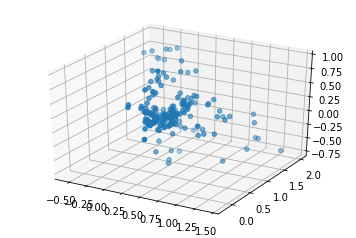

In [5]:
data_A_sample = data_A[0]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_A_sample [:,0],data_A_sample [:,1],data_A_sample [:,2]);

### Vietoris-Rips complex


The [$\alpha$-Rips complex](https://en.wikipedia.org/wiki/Vietoris%E2%80%93Rips_complex) of a point cloud $\mathbb X$ in $(\mathbb R^d,\| \|_2)$  is an [abstract simplicial complex](https://en.wikipedia.org/wiki/Abstract_simplicial_complex) that can be defined  by forming a simplex for every finite subset of $\mathbb X$ that has diameter at most $\alpha$.  Vietoris-Rips complexes can be defined for any metric space from the  matrix of a pairwise distances, see this [notebook](Tuto-GUDHI-simplicial-complexes-from-distance-matrix.ipynb).

The <code>RipsComplex()</code> function creates a [one skeleton](https://en.wikipedia.org/wiki/N-skeleton) graph from the point cloud, see the [Documentation](http://gudhi.gforge.inria.fr/python/latest/rips_complex_user.html) for details on the syntax.

In [6]:
skeleton  = gd.RipsComplex(points = data_A_sample,max_edge_length=0.2 )

The `max_edge_length` parameter is the maximal diameter: only the edges of length less vers this value are included in the one skeleton graph. 

Next, we create the Rips simplicial complex from this one-skeleton graph. This is a filtered Rips complex which filtration function is exacly the diameter of the simplices. We use the `create_simplex_tree()` function:

In [7]:
Rips_simplex_tree_sample = skeleton.create_simplex_tree(max_dimension=3) 

The `max_dimension` parameter is the maximum dimension of the simplices included in the the filtration. The object returned by the function is a simplex tree, of dimension 3 in this example:

In [8]:
Rips_simplex_tree_sample.dimension()

3

We can use the fonctionalites of the simplex tree object to describe the Rips filtration.
For instance we can check that the 200 points of `data_A_sample` are all vertices of the Rips filtration:

In [9]:
print(Rips_simplex_tree_sample.num_vertices())

200


The number of simplexes in the Rips complex is:

In [10]:
print(Rips_simplex_tree_sample.num_simplices())

27851


Note that this is actually the number of simplices in the "last" Rips complex of the filtration, namely with parameter $\alpha=$ `max_edge_length=`0.2. 

Notice that the number of simplices in a Rips complex increases very fast with the number of points and the dimension.

Now let's compute the list of simplices in the Rips complex with the `get_filtration() ` function:

In [11]:
filt_Rips = Rips_simplex_tree_sample.get_filtration() 

Let's print 300 the first elements in the list :

In [12]:
for splx in filt_Rips[0:300] :
    print(splx)

([0], 0.0)
([1], 0.0)
([2], 0.0)
([3], 0.0)
([4], 0.0)
([5], 0.0)
([6], 0.0)
([7], 0.0)
([8], 0.0)
([9], 0.0)
([10], 0.0)
([11], 0.0)
([12], 0.0)
([13], 0.0)
([14], 0.0)
([15], 0.0)
([16], 0.0)
([17], 0.0)
([18], 0.0)
([19], 0.0)
([20], 0.0)
([21], 0.0)
([22], 0.0)
([23], 0.0)
([24], 0.0)
([25], 0.0)
([26], 0.0)
([27], 0.0)
([28], 0.0)
([29], 0.0)
([30], 0.0)
([31], 0.0)
([32], 0.0)
([33], 0.0)
([34], 0.0)
([35], 0.0)
([36], 0.0)
([37], 0.0)
([38], 0.0)
([39], 0.0)
([40], 0.0)
([41], 0.0)
([42], 0.0)
([43], 0.0)
([44], 0.0)
([45], 0.0)
([46], 0.0)
([47], 0.0)
([48], 0.0)
([49], 0.0)
([50], 0.0)
([51], 0.0)
([52], 0.0)
([53], 0.0)
([54], 0.0)
([55], 0.0)
([56], 0.0)
([57], 0.0)
([58], 0.0)
([59], 0.0)
([60], 0.0)
([61], 0.0)
([62], 0.0)
([63], 0.0)
([64], 0.0)
([65], 0.0)
([66], 0.0)
([67], 0.0)
([68], 0.0)
([69], 0.0)
([70], 0.0)
([71], 0.0)
([72], 0.0)
([73], 0.0)
([74], 0.0)
([75], 0.0)
([76], 0.0)
([77], 0.0)
([78], 0.0)
([79], 0.0)
([80], 0.0)
([81], 0.0)
([82], 0.0)
([83], 0.0)
([

The filtration value is the diameter of the simplex, which is zero for the vertices of course. The first edge in the filtration is [6, 34], these two points are the two closest points in `data_A_sample`, at distance 0.0100 of each other. If you scroll down you will see that the first triangle is [4, 53, 191], for the filtration value 0.0327.

### Alpha complex 

The [alpha complexes](https://en.wikipedia.org/wiki/Alpha_shape#Alpha_complex) is a  
simplicial complex constructed from the finite cells of a [Delaunay Triangulation](https://en.wikipedia.org/wiki/Delaunay_triangulation). Alpha complexes contain less simplices than Rips complexes do and so it can be a better option than Rips complexes. As subcomplexes of the Delaunay Triangulation complex, an alpha complex is a geometric simpicial complex.

The `AlphaComplex()` function directly computes the simplex tree representing the Alpha complex:

In [13]:
alpha_complex = gd.AlphaComplex(points=data_A_sample)

In [14]:
st_alpha = alpha_complex.create_simplex_tree()

The point cloud `data_A_sample` belongs to $\mathbb R^3$ and so does the Alpha Complex:

In [15]:
st_alpha.dimension()

3

As for the Rips complex, the 200 points of `data_A_sample` are all vertices of the Alpha complex :

In [16]:
print(st_alpha.num_vertices())

200


Note that the number of simplexes in the Alpha complex is smaller then for the Rips complex:

In [17]:
print(st_alpha.num_simplices())

5085
